## Vehicle Detection

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
# from sklearn import svm, grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading Dataset

In [2]:
# Read in car and non-car images
# images = glob.glob('kitti/*/KITTI/*.png') # Only KITTI Dataset
images = glob.glob('kitti/*/*/*.png')       # KITTI + GTI (Unique Vehicle Right)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
print('Total Number of Images: ', len(images))
print('Total Not Car Images: ', len(notcars))
print('Total Car Images: ', len(cars))

Total Number of Images:  15112
Total Not Car Images:  8968
Total Car Images:  6144


## Helper Functions

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Extract features function
This extracts features from an image passed including binned color and histogram features

In [4]:
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                         hist_bins=32, hist_range=(0, 256),
                         orient= 9, pix_per_cell= 8, cell_per_block= 2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         else: feature_image = np.copy(image)  
        feature_image = convert_color(image, conv='RGB2YCrCb')
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply HOG
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
    
    # Return list of feature vectors
    return features

## Data Preprocessing
Feature Extraction, Randomize data and Normalization

In [5]:
# performs under different binning scenarios
spatial = 32
histbin = 64

cspace='RGB'
spatial_size=(spatial, spatial)
hist_bins=histbin
hist_range=(0, 256)
orient= 9
pix_per_cell= 8
cell_per_block= 2
hog_channel='ALL'

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2,hog_channel='ALL')
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, hog_channel='ALL')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Using spatial binning of: 32 and 64 histogram bins
Feature vector length: 8556


## Model Training
Iterating through C=1-10 in increments of 1 (Since GridSearch with linear kernel doesn't give similar results)

In [6]:
# Use a linear SVC 
# svr = svm.SVC()
# svc = grid_search.GridSearchCV(svr, parameters)
best_clf = None
acc = 0
total_time = 0
best_C = None
for i in range(1,10):
    svc = None
    C_p = i
    svc = LinearSVC(C=C_p)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('C is ', C_p)
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    print('----------')
    
    if accuracy > acc:
        acc = accuracy
        best_clf = svc
        best_C = C_p
        
    total_time += round(t2-t, 5)
    
# svc = None
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# accuracy = round(svc.score(X_test, y_test), 4)
# print('Test Accuracy of SVC = ', accuracy)
# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# print('----------')
    

C is  1
5.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00145 Seconds to predict 10 labels with SVC
----------
C is  2
5.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00179 Seconds to predict 10 labels with SVC
----------
C is  3
5.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00186 Seconds to predict 10 labels with SVC
----------
C is  4
5.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
0.00168 Seconds to predict 10 labels with SVC
----------
C is

## Saving Model

In [7]:
import pickle

print('Best Accuracy is ', acc, ' at C = ', best_C)
list_pickle = open('svcmodel', 'wb')
pickle_dict = {'svc': best_clf,
               'scaler': X_scaler,
               'orient': orient,
               'pix_per_cell': pix_per_cell,
               'cell_per_block': cell_per_block,
               'spatial_size': spatial_size,
               'hist_bins': hist_bins}


pickle.dump(pickle_dict, list_pickle)
list_pickle.close()

Best Accuracy is  0.9957  at C =  1


## Hog Subsampling

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                c_left = xbox_left, ytop_draw+ystart
                c_right = xbox_left+win_draw,ytop_draw+win_draw+ystart
                bbox = c_left, c_right
                box_list.append(bbox)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
    return box_list, draw_img

## Load Saved Model

In [9]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open('svcmodel.p', 'rb' ) )

# get attributes of our svc object
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Test on an image

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


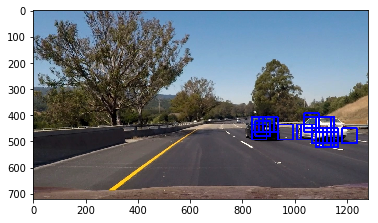

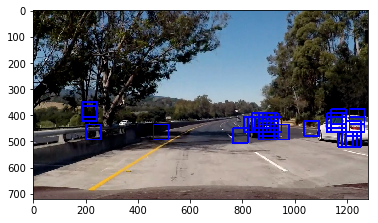

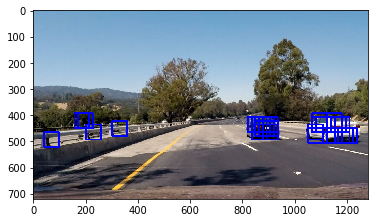

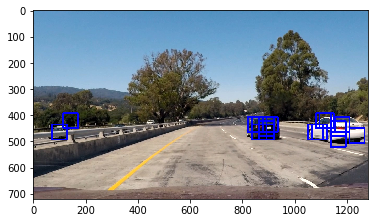

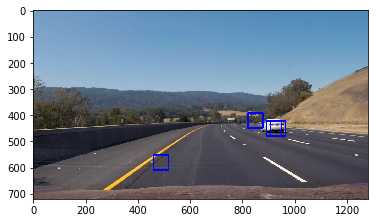

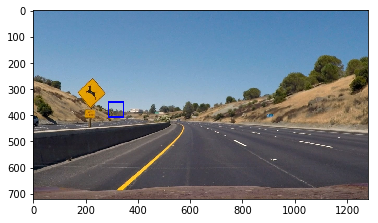

In [11]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# img = img.astype(np.float32)/255

ystart = 350
ystop = 656
scale = 0.9

# img = mpimg.imread('test_images/test3.jpg')
# box_list, draw_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
# plt.imshow(draw_img)
# plt.show()

test_imgs = glob.glob('test_images/*.jpg')
for image in test_imgs:
    img = mpimg.imread(image)
    box_list, draw_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    plt.imshow(draw_img)
    plt.show()

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


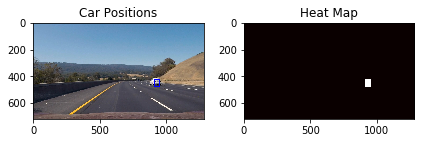

In [12]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test3.jpg')
box_list, draw_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## Pipeline

In [204]:
def process_image(img):
    
    box_list, d_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

In [205]:
# Import everything needed to edit/save/watch video clips
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test_video_out3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_video.mp4')
test_clip = clip3.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_out3.mp4
[MoviePy] Writing video test_video_out3.mp4





  0%|          | 0/39 [00:00<?, ?it/s]


  3%|▎         | 1/39 [00:01<01:10,  1.85s/it]


  5%|▌         | 2/39 [00:03<01:07,  1.83s/it]


  8%|▊         | 3/39 [00:05<01:05,  1.82s/it]


 10%|█         | 4/39 [00:07<01:03,  1.81s/it]


 13%|█▎        | 5/39 [00:09<01:01,  1.80s/it]


 15%|█▌        | 6/39 [00:10<00:59,  1.79s/it]


 18%|█▊        | 7/39 [00:12<00:57,  1.79s/it]


 21%|██        | 8/39 [00:14<00:55,  1.79s/it]


 23%|██▎       | 9/39 [00:16<00:53,  1.79s/it]


 26%|██▌       | 10/39 [00:17<00:51,  1.79s/it]


 28%|██▊       | 11/39 [00:19<00:50,  1.79s/it]


 31%|███       | 12/39 [00:21<00:48,  1.79s/it]


 33%|███▎      | 13/39 [00:23<00:46,  1.79s/it]


 36%|███▌      | 14/39 [00:25<00:44,  1.79s/it]


 38%|███▊      | 15/39 [00:26<00:42,  1.79s/it]


 41%|████      | 16/39 [00:28<00:41,  1.80s/it]


 44%|████▎     | 17/39 [00:30<00:39,  1.79s/it]


 46%|████▌     | 18/39 [00:32<00:37,  1.79s/it]


 49%|████▊     | 19/39 [00:34<00:35,  1.79s/it]


 51%|█████▏    

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out3.mp4 

CPU times: user 1min 7s, sys: 1.19 s, total: 1min 9s
Wall time: 1min 9s


In [206]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_clip))

In [207]:
challenge_output = 'project_video_out_full_1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_video_out_full_1.mp4
[MoviePy] Writing video project_video_out_full_1.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:01<37:40,  1.79s/it]


  0%|          | 2/1261 [00:03<37:01,  1.76s/it]


  0%|          | 3/1261 [00:05<36:57,  1.76s/it]


  0%|          | 4/1261 [00:07<37:04,  1.77s/it]


  0%|          | 5/1261 [00:08<36:52,  1.76s/it]


  0%|          | 6/1261 [00:10<36:41,  1.75s/it]


  1%|          | 7/1261 [00:12<36:41,  1.76s/it]


  1%|          | 8/1261 [00:14<36:32,  1.75s/it]


  1%|          | 9/1261 [00:15<36:26,  1.75s/it]


  1%|          | 10/1261 [00:17<36:21,  1.74s/it]


  1%|          | 11/1261 [00:19<36:18,  1.74s/it]


  1%|          | 12/1261 [00:20<36:13,  1.74s/it]


  1%|          | 13/1261 [00:22<36:13,  1.74s/it]


  1%|          | 14/1261 [00:24<36:14,  1.74s/it]


  1%|          | 15/1261 [00:26<36:13,  1.74s/it]


  1%|▏         | 16/1261 [00:27<36:15,  1.75s/it]


  1%|▏         | 17/1261 [00:29<36:12,  1.75s/it]


  1%|▏         | 18/1261 [00:31<36:08,  1.74s/it]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [03:53<32:43,  1.74s/it]


 11%|█         | 135/1261 [03:55<32:41,  1.74s/it]


 11%|█         | 136/1261 [03:57<32:41,  1.74s/it]


 11%|█         | 137/1261 [03:58<32:40,  1.74s/it]


 11%|█         | 138/1261 [04:00<32:38,  1.74s/it]


 11%|█         | 139/1261 [04:02<32:36,  1.74s/it]


 11%|█         | 140/1261 [04:04<32:34,  1.74s/it]


 11%|█         | 141/1261 [04:05<32:33,  1.74s/it]


 11%|█▏        | 142/1261 [04:07<32:31,  1.74s/it]


 11%|█▏        | 143/1261 [04:09<32:29,  1.74s/it]


 11%|█▏        | 144/1261 [04:11<32:27,  1.74s/it]


 11%|█▏        | 145/1261 [04:12<32:25,  1.74s/it]


 12%|█▏        | 146/1261 [04:14<32:24,  1.74s/it]


 12%|█▏        | 147/1261 [04:16<32:22,  1.74s/it]


 12%|█▏        | 148/1261 [04:18<32:20,  1.74s/it]


 12%|█▏        | 149/1261 [04:19<32:18,  1.74s/it]


 12%|█▏        | 150/1261 [04:21<32:16,  1.74s/it]


 12%|█▏        | 151/1261 [04:23<32:14,  1.74s/it]


 12%|█▏        | 152/1261 [04:24<32:12,  1.74s

 32%|███▏      | 398/1261 [11:35<25:08,  1.75s/it]


 32%|███▏      | 399/1261 [11:37<25:06,  1.75s/it]


 32%|███▏      | 400/1261 [11:39<25:04,  1.75s/it]


 32%|███▏      | 401/1261 [11:40<25:03,  1.75s/it]


 32%|███▏      | 402/1261 [11:42<25:01,  1.75s/it]


 32%|███▏      | 403/1261 [11:44<24:59,  1.75s/it]


 32%|███▏      | 404/1261 [11:46<24:57,  1.75s/it]


 32%|███▏      | 405/1261 [11:47<24:56,  1.75s/it]


 32%|███▏      | 406/1261 [11:49<24:54,  1.75s/it]


 32%|███▏      | 407/1261 [11:51<24:52,  1.75s/it]


 32%|███▏      | 408/1261 [11:53<24:50,  1.75s/it]


 32%|███▏      | 409/1261 [11:54<24:49,  1.75s/it]


 33%|███▎      | 410/1261 [11:56<24:47,  1.75s/it]


 33%|███▎      | 411/1261 [11:58<24:45,  1.75s/it]


 33%|███▎      | 412/1261 [12:00<24:43,  1.75s/it]


 33%|███▎      | 413/1261 [12:01<24:42,  1.75s/it]


 33%|███▎      | 414/1261 [12:03<24:40,  1.75s/it]


 33%|███▎      | 415/1261 [12:05<24:38,  1.75s/it]


 33%|███▎      | 416/1261 [12:07<24:36,  1.75s

 52%|█████▏    | 662/1261 [19:17<17:26,  1.75s/it]


 53%|█████▎    | 663/1261 [19:18<17:25,  1.75s/it]


 53%|█████▎    | 664/1261 [19:20<17:23,  1.75s/it]


 53%|█████▎    | 665/1261 [19:22<17:21,  1.75s/it]


 53%|█████▎    | 666/1261 [19:23<17:19,  1.75s/it]


 53%|█████▎    | 667/1261 [19:25<17:18,  1.75s/it]


 53%|█████▎    | 668/1261 [19:27<17:16,  1.75s/it]


 53%|█████▎    | 669/1261 [19:29<17:14,  1.75s/it]


 53%|█████▎    | 670/1261 [19:30<17:12,  1.75s/it]


 53%|█████▎    | 671/1261 [19:32<17:11,  1.75s/it]


 53%|█████▎    | 672/1261 [19:34<17:09,  1.75s/it]


 53%|█████▎    | 673/1261 [19:36<17:07,  1.75s/it]


 53%|█████▎    | 674/1261 [19:37<17:05,  1.75s/it]


 54%|█████▎    | 675/1261 [19:39<17:04,  1.75s/it]


 54%|█████▎    | 676/1261 [19:41<17:02,  1.75s/it]


 54%|█████▎    | 677/1261 [19:43<17:00,  1.75s/it]


 54%|█████▍    | 678/1261 [19:44<16:58,  1.75s/it]


 54%|█████▍    | 679/1261 [19:46<16:57,  1.75s/it]


 54%|█████▍    | 680/1261 [19:48<16:55,  1.75s

 73%|███████▎  | 926/1261 [26:57<09:45,  1.75s/it]


 74%|███████▎  | 927/1261 [26:59<09:43,  1.75s/it]


 74%|███████▎  | 928/1261 [27:01<09:41,  1.75s/it]


 74%|███████▎  | 929/1261 [27:02<09:39,  1.75s/it]


 74%|███████▍  | 930/1261 [27:04<09:38,  1.75s/it]


 74%|███████▍  | 931/1261 [27:06<09:36,  1.75s/it]


 74%|███████▍  | 932/1261 [27:08<09:34,  1.75s/it]


 74%|███████▍  | 933/1261 [27:09<09:32,  1.75s/it]


 74%|███████▍  | 934/1261 [27:11<09:31,  1.75s/it]


 74%|███████▍  | 935/1261 [27:13<09:29,  1.75s/it]


 74%|███████▍  | 936/1261 [27:15<09:27,  1.75s/it]


 74%|███████▍  | 937/1261 [27:16<09:26,  1.75s/it]


 74%|███████▍  | 938/1261 [27:18<09:24,  1.75s/it]


 74%|███████▍  | 939/1261 [27:20<09:22,  1.75s/it]


 75%|███████▍  | 940/1261 [27:22<09:20,  1.75s/it]


 75%|███████▍  | 941/1261 [27:23<09:19,  1.75s/it]


 75%|███████▍  | 942/1261 [27:25<09:17,  1.75s/it]


 75%|███████▍  | 943/1261 [27:27<09:15,  1.75s/it]


 75%|███████▍  | 944/1261 [27:29<09:13,  1.75s

 94%|█████████▍| 1187/1261 [34:33<02:09,  1.75s/it]


 94%|█████████▍| 1188/1261 [34:35<02:07,  1.75s/it]


 94%|█████████▍| 1189/1261 [34:37<02:05,  1.75s/it]


 94%|█████████▍| 1190/1261 [34:38<02:04,  1.75s/it]


 94%|█████████▍| 1191/1261 [34:40<02:02,  1.75s/it]


 95%|█████████▍| 1192/1261 [34:42<02:00,  1.75s/it]


 95%|█████████▍| 1193/1261 [34:44<01:58,  1.75s/it]


 95%|█████████▍| 1194/1261 [34:45<01:57,  1.75s/it]


 95%|█████████▍| 1195/1261 [34:47<01:55,  1.75s/it]


 95%|█████████▍| 1196/1261 [34:49<01:53,  1.75s/it]


 95%|█████████▍| 1197/1261 [34:51<01:51,  1.75s/it]


 95%|█████████▌| 1198/1261 [34:52<01:50,  1.75s/it]


 95%|█████████▌| 1199/1261 [34:54<01:48,  1.75s/it]


 95%|█████████▌| 1200/1261 [34:56<01:46,  1.75s/it]


 95%|█████████▌| 1201/1261 [34:58<01:44,  1.75s/it]


 95%|█████████▌| 1202/1261 [34:59<01:43,  1.75s/it]


 95%|█████████▌| 1203/1261 [35:01<01:41,  1.75s/it]


 95%|█████████▌| 1204/1261 [35:03<01:39,  1.75s/it]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_full_1.mp4 

CPU times: user 36min 20s, sys: 38.6 s, total: 36min 58s
Wall time: 36min 41s
